This is a test implemenimplementation of the original Alanine M+1 tutorial script by Timothy Csernica 2023.
Phytol is much larger and more complex then Alanine but I will give it a try..
By Merve Öztoprak

We will try to simulate a Phytol molecule. 

We begin by importing the different python files and libraries we need. We start with "sys.path.insert" to allow us to import from the parent directory; this allows us to have a parent directory with all the code, and a separate folder to keep our notebooks and other data. 

In [1]:
import sys; sys.path.insert(0, '..')

from datetime import date

today = date.today()

import copy
import json

import numpy as np
import pandas as pd
from tqdm import tqdm

import basicDeltaOperations as op
import calcIsotopologues as ci
import fragmentAndSimulate as fas

Our first step is to initialize some basic information about the molecule. This is done via four separate lists of the same length giving information about the various sites. 

IDList gives each a name (arbitrary; by convention the first letter(s) give the element)

elIDs gives the identity of each element ("C", "O", "N", "H", and "S" are supported) 

numberAtSite gives the number of atoms at that particular site (as defined in the theory paper, sites contain any number of atoms of a single element)

deltas gives the site specific deltas for the M+1 substitution at each site (13C, 17O, 15N, 33S, D). Other deltas (18O, 34S, 36S) are set assuming a mass scaling relationship with the M+1 substitution. We do not include any information about clumps at present. The reference frames are VPDB, VSMOW, AIR, and CDT; see basicDeltaOperations file for the standard constants.

I have assigned each carbon atom a specific site, except the methyl site, here 2 carbon atoms are combined to one site. The hydroxy site is also a site

In [2]:
IDList = ["Ohydroxy","C1","C2unsat","C3methyl","C4","C5","C6","C7methyl","C8","C9","C10","C11methyl","C12","C13","C14","C15doublemethyl"]
elIDs = ["O","C","C","C","C","C","C","C","C","C","C","C","C","C","C","C"]
numberAtSite = [1,1,1,2,1,1,1,2,1,1,1,2,1,1,1,3]
deltas = [-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7]

l = [elIDs, numberAtSite, deltas]
cols = ['IDS','Number','deltas']

Next, we define the fragmentation dictionary for this molecule. This is done via a two step process; first we define a dictionary "allFragments" giving information about every possible fragment of this molecule; we then define a "fragSubset" list giving the names of the fragments we are using for this experiment, and construct the actual dictionary by pulling out relevant fragments. This makes it easy to add or remove fragments for given experiments. 

At present, there are no automatic checks to make sure an input fragmentation pattern is valid--they must be checked manually. Part of the value of simulating and solving a synthetic dataset is confirming everything is defined properly. 

I have tried to list all relevant fragments for our MS1 and MS2 experiments including doubly and triply unsaturated fragments and fragments containing Oxygen except 127 m/Z C8H15O b/c I dont know how that can form?

In [3]:
allFragments = {'full':{'01':{'subgeometry':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],'relCont':1}},
                '67':{'01':{'subgeometry':['x','x','x','x',1,1,1,1,'x','x','x','x','x','x','x','x'],'relCont':0.25},
                      '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,'x','x','x','x','x'],'relCont':0.25},
                      '03':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,'x','x','x','x'],'relCont':0.25},
                       '04':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x',1,1,1,1,'x'],'relCont':0.25}},
                '69':{'01':{'subgeometry':['x','x','x','x',1,1,1,1,'x','x','x','x','x','x','x','x'],'relCont':0.25},
                      '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,'x','x','x','x','x'],'relCont':0.25},
                      '03':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,'x','x','x','x'],'relCont':0.25},
                       '04':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x',1,1,1,1,'x'],'relCont':0.25}},
                '71':{'01':{'subgeometry':['x','x','x','x',1,1,1,1,'x','x','x','x','x','x','x','x'],'relCont':0.25},
                      '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,'x','x','x','x','x'],'relCont':0.25},
                      '03':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,'x','x','x','x'],'relCont':0.25},
                       '04':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x',1,1,1,1,'x'],'relCont':0.25}},
                '81':{'01':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x','x',1,1,1,1],'relCont':1}},
                '83':{'01':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x','x',1,1,1,1],'relCont':1}},
                '85':{'01':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x','x',1,1,1,1],'relCont':1}},
                '95':{'01':{'subgeometry':['x',1,1,1,1,1,1,'x','x','x','x','x','x','x','x','x'],'relCont':0.9},
                       '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,1,'x','x','x','x'],'relCont':0.1}},
                '97':{'01':{'subgeometry':['x',1,1,1,1,1,1,'x','x','x','x','x','x','x','x','x'],'relCont':0.9},
                       '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,1,'x','x','x','x'],'relCont':0.1}},
                '99':{'01':{'subgeometry':['x',1,1,1,1,1,1,'x','x','x','x','x','x','x','x','x'],'relCont':0.9},
                       '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,1,'x','x','x','x'],'relCont':0.1}},
                '109':{'01':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x',1,1,1,1,1],'relCont':0.8},
                       '02':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,1,1,1,'x'],'relCont':0.1},
                       '03':{'subgeometry':['x','x','x','x',1,1,1,1,1,1,1,'x','x','x','x','x'],'relCont':0.1}},
                '111':{'01':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x',1,1,1,1,1],'relCont':0.8},
                       '02':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,1,1,1,'x'],'relCont':0.1},
                       '03':{'subgeometry':['x','x','x','x',1,1,1,1,1,1,1,'x','x','x','x','x'],'relCont':0.1}},
                '113':{'01':{'subgeometry':['x','x','x','x','x','x','x','x','x','x','x',1,1,1,1,1],'relCont':0.8},
                       '02':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,1,1,1,'x'],'relCont':0.1},
                       '03':{'subgeometry':['x','x','x','x',1,1,1,1,1,1,1,'x','x','x','x','x'],'relCont':0.1}},
                '123':{'01':{'subgeometry':['x',1,1,1,1,1,1,1,'x','x','x','x','x','x','x','x'],'relCont':1}},
                '125':{'01':{'subgeometry':['x',1,1,1,1,1,1,1,'x','x','x','x','x','x','x','x'],'relCont':1}},
                '127':{'01':{'subgeometry':['x',1,1,1,1,1,1,1,'x','x','x','x','x','x','x','x'],'relCont':1}},
                '137':{'01':{'subgeometry':['x','x','x','x',1,1,1,1,1,1,1,1,'x','x','x','x'],'relCont':0.9},
                       '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,1,1,1,1,'x'],'relCont':0.1}},
                '139':{'01':{'subgeometry':['x','x','x','x',1,1,1,1,1,1,1,1,'x','x','x','x'],'relCont':0.9},
                       '02':{'subgeometry':['x','x','x','x','x','x','x',1,1,1,1,1,1,1,1,'x'],'relCont':0.1}},
                '151':{'01':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,1,1,1,1],'relCont':1}},
                '153':{'01':{'subgeometry':['x','x','x','x','x','x','x','x',1,1,1,1,1,1,1,1],'relCont':1}},
                '165':{'01':{'subgeometry':['x',1,1,1,1,1,1,1,1,1,1,'x','x','x','x','x'],'relCont':1}},
                 '167':{'01':{'subgeometry':['x',1,1,1,1,1,1,1,1,1,1,'x','x','x','x','x'],'relCont':1}}}

fragSubset = ['full','67','69','71','81','83','85','95','97','99',
             '109','111','113','123','125','127','137','139',
             '151','153','165','167']

fragmentationDictionary = {key: value for key, value in allFragments.items() if key in fragSubset}

Next, we process this fragmentation information to create two lists: condensedFrags and fragKeys.

fragKeys contains a string for each subgeometry, written as e.g. ['full_01','44_01']. This variable tracks all subfragments, not just the observed fragments. 

condensedFrags is a list of lists; each list specifies the particular subgeometry sampled by that fragment. For example, condensedFrags = [[1, 1, 1, 1, 1, 1], [1, 'x', 'x', 1, 1, 'x']], for full_01 and 44_01, respectively. 

In [4]:
siteFrags =[]
fragSubgeometryKeys = []
    
for fragKey, subFragDict in fragmentationDictionary.items():
    for subFragNum, subFragInfo in subFragDict.items():
        l.append(subFragInfo['subgeometry'])
        cols.append(fragKey + '_' + subFragNum)
        siteFrags.append(subFragInfo['subgeometry'])
        fragSubgeometryKeys.append(fragKey + '_' + subFragNum)

We then define an additional way to track fragmentation, the "expandedFrags" variable. This is similar to condensed frags, but expands entries for multiatomic sites to give one entry per atom, as opposed to one entry for the site. 

We call the condensedFrags depiction the "SITE" depiction of our molecule.

We call the expandedFrags depiction the "ATOM" depiction of our molecule. Note that we may also expand elIDs and delta values from the "SITE" depiction to the "ATOM" depiction. We will make use of both depictions. 

In [5]:
atomFrags = [fas.expandFrag(x, numberAtSite) for x in siteFrags]

In [6]:
atomFrags

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 ['x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x',
  'x',
  'x',
  'x',
  'x'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x',
  'x'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x'],
 ['x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  'x',
  1,
  1,
  1,
  1,
  1,
  'x',
  'x

Finally, we put all this information into a dataFrame to track basic information about this molecule. 

In [7]:
df = pd.DataFrame(l, columns = IDList)
df = df.transpose()
df.columns = cols

df

,IDS,Number,deltas,full_01,67_01,67_02,67_03,67_04,69_01,69_02,...,125_01,127_01,137_01,137_02,139_01,139_02,151_01,153_01,165_01,167_01
Ohydroxy,O,1,-30.7,1,x,x,x,x,x,x,...,x,x,x,x,x,x,x,x,x,x
C1,C,1,-30.7,1,x,x,x,x,x,x,...,1,1,x,x,x,x,x,x,1,1
C2unsat,C,1,-30.7,1,x,x,x,x,x,x,...,1,1,x,x,x,x,x,x,1,1
C3methyl,C,2,-30.7,1,x,x,x,x,x,x,...,1,1,x,x,x,x,x,x,1,1
C4,C,1,-30.7,1,1,x,x,x,1,x,...,1,1,1,x,1,x,x,x,1,1
C5,C,1,-30.7,1,1,x,x,x,1,x,...,1,1,1,x,1,x,x,x,1,1
C6,C,1,-30.7,1,1,x,x,x,1,x,...,1,1,1,x,1,x,x,x,1,1
C7methyl,C,2,-30.7,1,1,1,x,x,1,1,...,1,1,1,1,1,1,x,x,1,1
C8,C,1,-30.7,1,x,1,1,x,x,1,...,x,x,1,1,1,1,1,1,1,1
C9,C,1,-30.7,1,x,1,1,x,x,1,...,x,x,1,1,1,1,1,1,1,1


I want to save the output to play around in R later

In [8]:
df.to_csv(r'..\dfATOMinfo.csv')

Often, we will want to initialize the same molecule many times, with different delta values and/or fragments. We will write a function that does all of this behind the scenes, and accomplish it just by calling that function. 

I have adapted the alanineTest.py file to PhytolTest.py

In [9]:
import PhytolTest

deltas = [-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7]
fragSubset = ['full','67','69','71','81','83','85','95','97','99',
             '109','111','113','123','125','127','137','139',
             '151','153','165','167']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = PhytolTest.initializePhytol(deltas, fragSubset,
                                                                                    printHeavy = True)

Delta 18O
-59.03846153846138


With this basic information, we can begin simulating a measurement. We start by calculating the concentration of all isotopologues of a molecule; this is viable computationally for molecules with millions of distinct isotopologues. 

I have only calculated concentrations for the M+1 population of interest

In [10]:
#disable disables the progress bar
byAtom = ci.inputToAtomDict(df, disable = False, M1Only = True)

Calculating Isotopologue Concentrations


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17025.59it/s]


Compiling Isotopologue Dictionary


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 8501.63it/s]


Our output is a dictionary. The keys are strings with length equal to the number of atoms (NOT # of sites) in the molecule; i.e., they correspond to the ATOM depiction. We can track the element IDs at each position of the string with the following function.

In [11]:
ci.strSiteElements(df)

'OCCCCCCCCCCCCCCCCCCCC'

Our dictionary contains the following information:

Number: The number of indistinguishable isotopologues with this geometry. 

Full: An expanded version of the ATOM depiction. Each multiatomic site, with n atoms, contains n numbers in parentheses corresponding to the individual atoms. These are indistinguishable; hence, rather than including (1,0) and (0,1) simultaneously, we only include (0,1), always using the version with leading zeroes. Review the theory paper for more details about this depiction. 

Conc: The sum of the concentration of all indistinguishable isotopologues with this geometry. Summing all concentrations in byAtom should yield 1. 

Mass: The cardinal mass difference between this isotopologue and the unsubstituted isotopologue. This is obtained by summing across the byAtom string. 

Subs: The identity of any substitutions in this isotopologue. 

Note that we calculate the ATOM depiction from the full depiction, which for the above example would include (0,1) but not (1,0). This means 01 would be a key in byAtom but 10 would not be. It is rarely recommended that one index into byAtom manually. 

In [12]:
byAtom

{'000000000000000000000': {'Number': 1,
  'Full': '000(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
  'Conc': 0.8042685457716979,
  'Mass': 0,
  'Subs': ''},
 '100000000000000000000': {'Number': 1,
  'Full': '100(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
  'Conc': 0.0002961614927881309,
  'Mass': 1,
  'Subs': '17O'},
 '010000000000000000000': {'Number': 1,
  'Full': '010(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
  'Conc': 0.008715676465836545,
  'Mass': 1,
  'Subs': '13C'},
 '001000000000000000000': {'Number': 1,
  'Full': '001(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
  'Conc': 0.008715676465836547,
  'Mass': 1,
  'Subs': '13C'},
 '000010000000000000000': {'Number': 2,
  'Full': '000(0, 1)000(0, 0)000(0, 0)000(0, 0, 0)',
  'Conc': 0.01743135293167309,
  'Mass': 1,
  'Subs': '13C'},
 '000001000000000000000': {'Number': 1,
  'Full': '000(0, 0)100(0, 0)000(0, 0)000(0, 0, 0)',
  'Conc': 0.008715676465836545,
  'Mass': 1,
  'Subs': '13C'},
 '000000100000000000000': {'Number': 1,
  'Full': '000(0, 0)010(0, 0)

At this point, one may add any clumps of interest. This is an advanced feature, so we do not discuss it here.

After adding clumps, we calculate a "bySub" dictionary. This contains similar information, but here the keys are substitutions ("D", "13C", etc.) and the information is given for all isotopologues with those substitutions. This makes it easier to calculate molecular average information and spectra. 

For Phytol Unsub is approx. 80.42%, for 17Osub 0.03% and for 13Csub 17.43%

In [13]:
bySub = ci.calcSubDictionary(byAtom, df, atomInput = True)

In [14]:
bySub

{'': {'Number': 1,
  'Full': ['000(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)'],
  'Conc': 0.8042685457716979,
  'Mass': [0],
  'ATOM': ['000000000000000000000']},
 '17O': {'Number': 1,
  'Full': ['100(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)'],
  'Conc': 0.0002961614927881309,
  'Mass': [1],
  'ATOM': ['100000000000000000000']},
 '13C': {'Number': 20,
  'Full': ['010(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   '001(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   '000(0, 1)000(0, 0)000(0, 0)000(0, 0, 0)',
   '000(0, 0)100(0, 0)000(0, 0)000(0, 0, 0)',
   '000(0, 0)010(0, 0)000(0, 0)000(0, 0, 0)',
   '000(0, 0)001(0, 0)000(0, 0)000(0, 0, 0)',
   '000(0, 0)000(0, 1)000(0, 0)000(0, 0, 0)',
   '000(0, 0)000(0, 0)100(0, 0)000(0, 0, 0)',
   '000(0, 0)000(0, 0)010(0, 0)000(0, 0, 0)',
   '000(0, 0)000(0, 0)001(0, 0)000(0, 0, 0)',
   '000(0, 0)000(0, 0)000(0, 1)000(0, 0, 0)',
   '000(0, 0)000(0, 0)000(0, 0)100(0, 0, 0)',
   '000(0, 0)000(0, 0)000(0, 0)010(0, 0, 0)',
   '000(0, 0)000(0, 0)000(0, 0)001(0, 0, 0)',
   '0

We then simulate the molecular average ("U value") measurement from the bySub dictionary. We can determine which measurements to simulate in two ways: first, we can specify a mass Threshold; all U values for substitutions below this cardinal mass difference will be calculated. Alternatively, we can enter a subList (including e.g. '13C', '15N'); in this case, U values will be calculated only for the indicated substitutions. 

Multiple substitutions are given without spaces (e.g. "18O18O"). Currently, we do not check for symmetry (e.g. if given "18O13C" it does not look for both "13C18O" and "18O13C"). The order must match the order given in the bySub dictionary (try bySub.keys())

I have only simulated 13C for Phytol

In [15]:
UValueList = ['13C']
allMeasurementInfo = {}
allMeasurementInfo = fas.UValueMeasurement(bySub, allMeasurementInfo, massThreshold = 3,
                                          subList = UValueList)

In [16]:
allMeasurementInfo

{'Full Molecule': {'13C': 0.21673547999999995}}

We next prepare to simulate M+N data. To do so, we first select only those isotopologues with cardinal mass differences of interest, explicitly enumerating the M+1, M+2, etc. populations. (Note that a faster version of our algorithm would calculate this directly, not calculating all isotopologues then selecting this subset)

In [17]:
MN = ci.massSelections(byAtom, massThreshold = 1)

In [18]:
MN

{'M0': {'000000000000000000000': {'Number': 1,
   'Full': '000(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.8042685457716979,
   'Mass': 0,
   'Subs': ''}},
 'M1': {'100000000000000000000': {'Number': 1,
   'Full': '100(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.0002961614927881309,
   'Mass': 1,
   'Subs': '17O'},
  '010000000000000000000': {'Number': 1,
   'Full': '010(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.008715676465836545,
   'Mass': 1,
   'Subs': '13C'},
  '001000000000000000000': {'Number': 1,
   'Full': '001(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.008715676465836547,
   'Mass': 1,
   'Subs': '13C'},
  '000010000000000000000': {'Number': 2,
   'Full': '000(0, 1)000(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.01743135293167309,
   'Mass': 1,
   'Subs': '13C'},
  '000001000000000000000': {'Number': 1,
   'Full': '000(0, 0)100(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.008715676465836545,
   'Mass': 1,
   'Subs': '13C'},
  '000000100000000000000':

We update this dictionary to include information about fragmentation. We do not use unresolvedDict here, which is an advanced feature allowing us to specify how unresolved ion beams combine.

The output dictionary calculates the stochastic U values for each isotopologue, the ATOM depiction of each isotopologue upon fragmentation, and the substituions of each isotopologue upon fragmentation. This makes it easy to predict spectra upon fragmentation for various M+N experiments. 

In [19]:
MN = fas.trackMNFragments(MN, atomFrags, fragSubgeometryKeys, df, unresolvedDict = {})

In [20]:
MN

{'M0': {'000000000000000000000': {'Number': 1,
   'Full': '000(0, 0)000(0, 0)000(0, 0)000(0, 0, 0)',
   'Conc': 0.8042685457716979,
   'Mass': 0,
   'Subs': '',
   'Stochastic U': 1.0,
   'full_01 Identity': '000000000000000000000',
   'full_01 Subs': 'Unsub',
   '67_01 Identity': 'xxxxx00000xxxxxxxxxxx',
   '67_01 Subs': 'Unsub',
   '67_02 Identity': 'xxxxxxxx00000xxxxxxxx',
   '67_02 Subs': 'Unsub',
   '67_03 Identity': 'xxxxxxxxxx00000xxxxxx',
   '67_03 Subs': 'Unsub',
   '67_04 Identity': 'xxxxxxxxxxxxx00000xxx',
   '67_04 Subs': 'Unsub',
   '69_01 Identity': 'xxxxx00000xxxxxxxxxxx',
   '69_01 Subs': 'Unsub',
   '69_02 Identity': 'xxxxxxxx00000xxxxxxxx',
   '69_02 Subs': 'Unsub',
   '69_03 Identity': 'xxxxxxxxxx00000xxxxxx',
   '69_03 Subs': 'Unsub',
   '69_04 Identity': 'xxxxxxxxxxxxx00000xxx',
   '69_04 Subs': 'Unsub',
   '71_01 Identity': 'xxxxx00000xxxxxxxxxxx',
   '71_01 Subs': 'Unsub',
   '71_02 Identity': 'xxxxxxxx00000xxxxxxxx',
   '71_02 Subs': 'Unsub',
   '71_03 Identity'

We then use this MN dictionary to simulate the M+N experiment of interest. The function here has many options:

abundanceThreshold: gives a relative abundance threshold (e.g. 0.01) below which peaks will not be observed. If a simulated ion beam has relative abundance below this threshold, it is culled from the predicted measurement. 

fractionationFactors: Advanced feature, not used here. Allows the user to specify experimental fractionation factors for each ion beam. 

omitMeasurements: Allows a user to manually specify ion beams to not measure. For example, omitMeasurements = {'M1':{'61':'D'}} would mean I do not observe the D ion beam of the 61 fragment of the M+1 experiment, regardless of its abundance. 

unresolvedDict: Discussed above. 

outputFull: For debugging; see following note. 

The FF output of the tuple contains fractionation factors used for this simulation. 

In [21]:
predictedMeasurement, FF = fas.predictMNFragmentExpt(allMeasurementInfo, MN, expandedFrags, fragSubgeometryKeys, df, 
                                                 fragmentationDictionary,
                                                 abundanceThreshold = 0, 
                                                     fractionationFactors = {}, 
                                                     omitMeasurements = {}, 
                                                     unresolvedDict = {}, 
                                                     outputFull = False)

PredictedMeasurement contains information about each observed ion beam, specifying its abundance four different ways (calculated stepwise):

Abs. Abundance gives the actual abundance in concentration space. 

Rel. Abundance gives the relative abundance compared to all ion beams (including unobserved ones) for this fragment. This is the quantity we hope to actually recover. 

Combined Rel. Abundance gives the relative abundance after combining any unresolved beams; for example, if the 17O beam adds to the 13C beam, the 13C beam will increase and 17O will equal 0. 

Adj. Rel. Abundance gives the relative abundance after culling those beams below the abundance threshold or manually omitted. This is the quantity we actually observe. 

See the theory paper for more details about each step. 

Note that beams which are not observed are culled from the dictionary, so information for these is not provided. Setting outputFull = True allows the user to see this information; however, note the dataset cannot be used in this case (as it includes data for unobserved beams). 

In [22]:
predictedMeasurement

{'Full Molecule': {'13C': 0.21673547999999995},
 'M0': {'full': {'Unsub': {'Abs. Abundance': 0.8042685457716979,
    'Rel. Abundance': 1.0,
    'Combined Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '67': {'Unsub': {'Abs. Abundance': 0.8042685457716979,
    'Rel. Abundance': 1.0,
    'Combined Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '69': {'Unsub': {'Abs. Abundance': 0.8042685457716979,
    'Rel. Abundance': 1.0,
    'Combined Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '71': {'Unsub': {'Abs. Abundance': 0.8042685457716979,
    'Rel. Abundance': 1.0,
    'Combined Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '81': {'Unsub': {'Abs. Abundance': 0.8042685457716979,
    'Rel. Abundance': 1.0,
    'Combined Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '83': {'Unsub': {'Abs. Abundance': 0.8042685457716979,
    'Rel. Abundance': 1.0,
    'Combined Rel. Abundance': 1.0,
    'Adj. Rel. Abundance': 1.0}},
  '85': {'Unsub': {'

Our primary data passing file is a .json format; this exports our simulated data as a .json. 

In [23]:
outputPath = str(today) + " Tutorial Phytol"
output = json.dumps(predictedMeasurement)

f = open(outputPath + ".json","w")
f.write(output)
f.close()

Typically, we will simulate the same molecule many times; again, we define a function simulateMeasurement in the PhytolTest.py folder, allowing easy access to the options of this function.

In [24]:
deltas = [-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7]
fragSubset = ['full','67','69','71','81','83','85','95','97','99',
             '109','111','113','123','125','127','137','139',
             '151','153','165','167']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = PhytolTest.initializePhytol(deltas, fragSubset)

unresolvedDict = {}
calcFF = False
forbiddenPeaks = {}
UValueList = ['13C']
abundanceThreshold = 0
massThreshold = 1

predictedMeasurement, MNDict, fractionationFactorsSmp = PhytolTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = abundanceThreshold,
                                                   outputPath = str(today) + " TUTORIAL Sample Stochastic",
                                                               calcFF = calcFF,
                                                               ffstd = 0.05,
                                                   unresolvedDict = unresolvedDict,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   massThreshold = massThreshold)

Delta 18O
-59.03846153846138
Calculating Isotopologue Concentrations


100%|███████████████████████████████████████████████████████████████████████| 663552/663552 [00:10<00:00, 64015.87it/s]


Compiling Isotopologue Dictionary


100%|███████████████████████████████████████████████████████████████████████| 663552/663552 [00:11<00:00, 59819.36it/s]


Simulating Measurement


In [26]:
deltas = [-10,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7]
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = PhytolTest.initializePhytol(deltas, fragSubset)

predictedMeasurement, MNDict, fractionationFactorsStd = PhytolTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = abundanceThreshold,
                                                   outputPath = str(today) + " TUTORIAL Standard Stochastic",
                                                               calcFF = calcFF,
                                                               ffstd = 0.05,
                                                   unresolvedDict = unresolvedDict,
                                                   fractionationFactors = fractionationFactorsSmp,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   massThreshold = massThreshold)

Delta 18O
-59.03846153846138
Calculating Isotopologue Concentrations


100%|███████████████████████████████████████████████████████████████████████| 663552/663552 [00:10<00:00, 64014.84it/s]


Compiling Isotopologue Dictionary


100%|███████████████████████████████████████████████████████████████████████| 663552/663552 [00:11<00:00, 58364.04it/s]


Simulating Measurement


Plot the simulated dataset using spectrumVis script

In [30]:
import spectrumVis as sV

deltas = [-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7,-30.7]
fragSubset = ['full','67','69','71','81','83','85','95','97','99',
             '109','111','113','123','125','127','137','139',
             '151','153','165','167']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = PhytolTest.initializePhytol(deltas, fragSubset)

Delta 18O
-59.03846153846138


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 8522.97it/s]


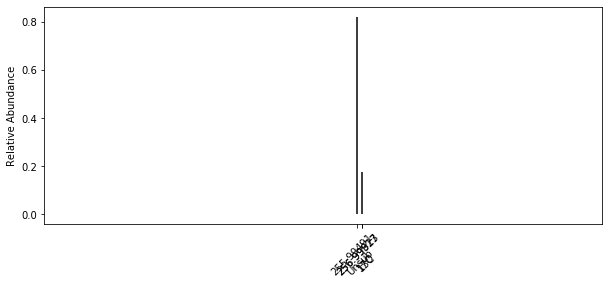

In [37]:
SimulatedFullSpectrum= sV.fullSpectrumVis(df, byAtom, figsize = (10,4), lowAbundanceCutOff = 0, massError = 0, 
xlim =(200,300), ylim = ())

I suspect something goes wrong in the strSiteElements function from calcIsotopolgues.py. I have several multiatomic sites which I have only given elIDs that are of a single atom. How do I implement multiatomic sites in this list?

100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17041.87it/s]


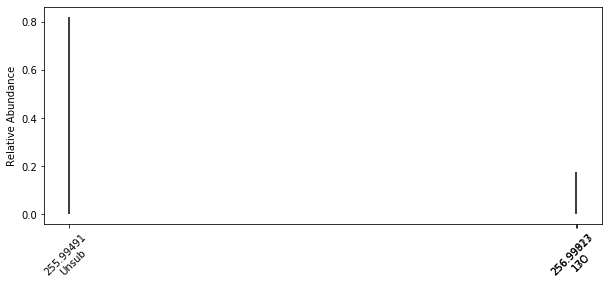

In [48]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd

selectedIsotopologues = byAtom
lowAbundanceCutOff = 0.00
massError = 0.000
figsize = (10,4)
xlim=(50-300)

siteElements = ci.strSiteElements(df)
predictSpectrum = {}
    
#calculates the mass of each isotopologue as well as its substitution. Adds its absolute concentration to the predicted 
#spectrum
for key, item in tqdm(selectedIsotopologues.items()):
    mass = fas.computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = fas.computeSubs(key, siteElements)

    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}

        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs

    predictSpectrum[correctedMass]['Abs. Abundance'] += item['Conc']
    
#Calculates the relative abundances, and places these, the masses, and substitutions into lists to plot. 
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']

massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
#Constructs a figure; does not plot peaks below the relative abundance cut off. 
fig, ax = plt.subplots(figsize = figsize)
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
ax.set_ylabel("Relative Abundance")
        
plt.show()
    

In [52]:
print(ci.strSiteElements(df))

OCCCCCCCCCCCCCCCCCCCC
